In [1]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator

from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore")

Research Question / Hypothesis
----




The objective is to classify the activity performed by smartphone users from the readings of various sensors in the smartphone while performing activities of daily living (WALKING, WALKINGUPSTAIRS, WALKINGDOWNSTAIRS, SITTING, STANDING, LAYING)

Load Data
----

In [5]:
def read_file(filename : str, url : str) -> pd.DataFrame:
    """Helper Function to fetch data files from github"""
    try:
        # Local version of the file
        df = pd.read_csv(filename)
    except FileNotFoundError or ParserError:
        # Grab the remote file and save it    
        url = remote_location+filename
        df = pd.read_csv(url)
        df.to_csv(filename)
    return df

In [6]:
remote_location = 'https://raw.githubusercontent.com/RahulBethavalli/sensor-activity-data/main/'

In [7]:
train_df = read_file('train.csv', remote_location)

In [8]:
test_df = read_file('test.csv', remote_location)

In [9]:
# Sanity check

print(train_df.shape)
print(test_df.shape)


(7352, 563)
(2947, 563)


In [10]:
train_df.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515,17.413085
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122,8.975143
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414,8.000000
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181,19.000000
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659,26.000000
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000,30.000000


In [14]:
train_df[['angle(X,gravityMean)', 'Activity']]

,"angle(X,gravityMean)",Activity
0,-0.841247,STANDING
1,-0.844788,STANDING
2,-0.848933,STANDING
3,-0.848649,STANDING
4,-0.847865,STANDING
...,...,...
7347,-0.791883,WALKING_UPSTAIRS
7348,-0.771840,WALKING_UPSTAIRS
7349,-0.779133,WALKING_UPSTAIRS
7350,-0.785181,WALKING_UPSTAIRS


In [40]:
# Look at the columns and group the columns taken from similar sensors. 

pd.DataFrame.from_dict(Counter([col.split('-')[0].split('(')[0] for col in train_df.columns]), \
                       orient='index').rename(columns={0:'count'}).sort_values('count', ascending=False)

,count
fBodyAcc,79
fBodyGyro,79
fBodyAccJerk,79
tGravityAcc,40
tBodyAcc,40
tBodyGyroJerk,40
tBodyGyro,40
tBodyAccJerk,40
tBodyAccMag,13
tGravityAccMag,13


In [149]:
# Check if data has any missing values

print(train_df.isnull().values.any())
print(test_df.isnull().values.any())

False
False


In [43]:
# After examining the features, dropping subject id as it is not a predictive feature

train_df = train_df.drop(columns=['subject']) 

In [44]:
# Print Value counts of the datatypes

train_df.dtypes.value_counts() 

float64    561
object       1
dtype: int64

In [45]:
test_df.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [151]:
# Making sure it is a balanced data. If not would leverage oversampling techniques

train_df.Activity.value_counts()

0    1407
2    1374
1    1286
3    1226
5    1073
4     986
Name: Activity, dtype: int64

#### Target Encoding

In [49]:
# As the target variable has categorical data, encoding it with LabelEncoder
# LabelEncoder can be used in this case since there are not many distinct classes in target

le = LabelEncoder()

train_df['Activity'] = le.fit_transform(train_df['Activity'])

In [50]:
# Verifying the encoding

train_df.Activity.value_counts()

0    1407
2    1374
1    1286
3    1226
5    1073
4     986
Name: Activity, dtype: int64

In [70]:
# Divide the loaded data into features and target

X = train_df.drop(columns='Activity')
y = train_df['Activity']

In [ ]:
# Split the training data into train and validation sets.

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 99)

#### MultiClass Classification Algorithms

In [103]:
# Select most relevant multiclass classification algorithms supported by sklearn 
# Initial Run of these algorithms to roughly determine a baseline model.


clf_algos = [
    LogisticRegression(solver='liblinear'),  # Since the dataset is small enough, using liblinear solver
    GaussianNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    RidgeClassifier(),
    KNeighborsClassifier(7),                 # Using 7 nearest neighbors since there are 6 target classes to break ties. 
    LinearSVC()
]

In [105]:
# Programmatically determine which naive models give good accuracy
# Using an imputer in case we get any missing values when predicting for future datasets into the pipeline.

for clf_algo in clf_algos:
    pipe = Pipeline([('scaler', StandardScaler()),  # Normalize the readings
                     ('imputer', SimpleImputer(strategy='median', add_indicator=True)),  
                     ('clf', clf_algo)])


    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_valid)
    # Since accuracy can be misleading, using f1_score to get good estimate of how model performs
    score = f1_score(y_valid, y_pred, average='macro')
    print(f"{clf_algo.__class__.__name__} - f1 score on validation set: {score:,.2f}")
    

LogisticRegression - f1 score on validation set: 0.98573152
GaussianNB - f1 score on validation set: 0.73741088
DecisionTreeClassifier - f1 score on validation set: 0.93944152
RandomForestClassifier - f1 score on validation set: 0.98099479
RidgeClassifier - f1 score on validation set: 0.98175501
KNeighborsClassifier - f1 score on validation set: 0.96076958
LinearSVC - f1 score on validation set: 0.98549643


/Users/rahulbethavalli/opt/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/svm/_base.py:974: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


We observe that we get decent model performance from different classifiers. Picking top three as model candidates.
- LogisticRegression
- RandomForestClassifier
- LinearSVC

#### Model and Hyperparameter tuning using Randomzed Search with Cross Validation

In [154]:
# Create Placeholder Estimator to use different algorithms

class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass


In [112]:
# Create a pipeline using the dummy estimator

pipe = Pipeline([('sc', StandardScaler()),
                 ('imputer', SimpleImputer(strategy='median', add_indicator=True)),
                ('clf', DummyEstimator())]) # Placeholder Estimator

In [117]:
# Create search space of candidate classifier algorithms and their hyperparameters

search_space = [{'clf': [LogisticRegression(solver = 'liblinear')], # Actual Estimator
                 'clf__penalty': ['l1', 'l2'],                      # Penalty scores for regularisation
                 'clf__C': np.logspace(0, 4, 10),                   # Inverse of regularisation parameter.
                 'clf__class_weight': [None, 'balanced'],           # Balanced class weight, weighs the predictions using the ratio of class frequencies 
                 'clf__n_jobs': [-1]                                
                },
                
                {'clf': [RandomForestClassifier()],
                 'clf__n_estimators': [10, 50, 100],                # No of trees that can be fit in the forest
                 'clf__criterion': ['gini', 'entropy'],             # Different impurity scores for the predictions 
                 'clf__max_depth': [5,20,50,100,200],               # Maimum depth of the trees 
                 'clf__min_samples_leaf': [np.arange(3, 10)],       # Minimum observations in a leaf node
                 'clf__bootstrap': [False, True],                   # flag to select bootstrapping of training data
                 'clf__n_jobs': [-1]
                },
                
               {'clf': [LinearSVC()],
                'clf__penalty': ['l1', 'l2'],                       # Penalty l1 and l2 for regularisation
                'clf__multi_class': ['ovr', 'crammer_singer'],      # ovr for OnevsRest approach
                'clf__max_iter': [2000, 5000],                      # Maximum Iterations for the model before converging
                'clf__C': np.logspace(0, 4, 10),                    # Regularisation parameter used
               }]

# Random Search for the possible combinations of the search space
clf_algos_rand = RandomizedSearchCV(estimator=pipe, 
                                    param_distributions=search_space, 
                                    n_iter=25,
                                    cv=5, 
                                    n_jobs=-1,
                                    verbose=1)


# Fit the training data
best_model = clf_algos_rand.fit(X_train, y_train)


Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 11.6min finished
/Users/rahulbethavalli/opt/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1351: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


In [118]:
# View best model
best_model.best_estimator_.get_params()['clf']

LogisticRegression(C=2.7825594022071245, n_jobs=-1, penalty='l1',
                   solver='liblinear')

In [120]:
# Print the best estimator
best_model.best_estimator_

Pipeline(steps=[('sc', StandardScaler()),
                ('imputer',
                 SimpleImputer(add_indicator=True, strategy='median')),
                ('clf',
                 LogisticRegression(C=2.7825594022071245, n_jobs=-1,
                                    penalty='l1', solver='liblinear'))])

In [121]:
pipe_final = Pipeline(steps=[('sc', StandardScaler()),
                ('imputer',
                 SimpleImputer(add_indicator=True, strategy='median')),
                ('clf',
                 LogisticRegression(C=2.7825594022071245, n_jobs=-1,
                                    penalty='l1', solver='liblinear'))])

In [125]:
# Fit the best model from random search with training data and evaluate the score for validation data. 

pipe_final.fit(X_train, y_train)
y_pred_train = pipe_final.predict(X_train)
y_pred_valid = pipe_final.predict(X_valid)
train_score = f1_score(y_train, y_pred_train, average='macro')
valid_score = f1_score(y_valid, y_pred_valid, average='macro')
print(f"best model f1 score on training set: {train_score:,.2f}")
print(f"best model f1 score on validation set: {valid_score:,.2f}")

/Users/rahulbethavalli/opt/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1351: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


best model f1 score on training set: 0.99726575
best model f1 score on validation set: 0.98677565


In [127]:
# Perform Cross validation to look at the variance of the model

cross_val_scores = cross_val_score(estimator=pipe_final, 
                X=X, 
                y=y, 
                cv=10, 
                scoring='f1_macro')

print("%0.2f f1_score with a standard deviation of %0.2f" % (cross_val_scores.mean(), cross_val_scores.std()))

/Users/rahulbethavalli/opt/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1351: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/rahulbethavalli/opt/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1351: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/rahulbethavalli/opt/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1351: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
/Users/rahulbethavalli/opt/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1351: UserWarning: 'n_jobs' > 1 does not have any eff

0.94812 accuracy with a standard deviation of 0.05640


The cross validation mean f1 score for the best model from the hyperparameter search is 94.81 which is pretty good for a classification model. 

Since we saw few weaker models with good enough f1 scores from the initial programmatical search of algorithms, we can try stacking them together to create an ensemble of classifiers which might result in a better model than our single best classifier from our random search

#### Stacked Model

In [146]:
# Stacking is appropriate when multiple different machine learning models have skill on a dataset, 
# but have different classification techniques. Hence we go with diverse classifiers in our stack.

estimators = [
        ('rf' ,RandomForestClassifier()),
        ('knn', KNeighborsClassifier(7)),
        ('ls', LinearSVC()),
        ('lc', LogisticRegression(solver = 'liblinear')),
]

stacked_clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=GradientBoostingClassifier()
)

pipe_stacked_clf = Pipeline([('sc', StandardScaler()),
                 ('imputer', SimpleImputer(strategy='median', add_indicator=True)),
                ('stacked_clf', stacked_clf)])


In [147]:
# Fit the stacked model on training data and evaluate the f1_scores for validation set.

pipe_stacked_clf.fit(X_train, y_train)
y_pred_train = pipe_stacked_clf.predict(X_train)
y_pred_valid = pipe_stacked_clf.predict(X_valid)
train_score = f1_score(y_train, y_pred_train, average='macro')
valid_score = f1_score(y_valid, y_pred_valid, average='macro')
print(f"best model f1 score on training set: {train_score:,.2f}")
print(f"best model f1 score on validation set: {valid_score:,.2f}")

best model f1 score on training set: 1.00
best model f1 score on validation set: 0.99


In [148]:
# Perform Cross validation to look at the variance of the stacked model

cross_val_scores = cross_val_score(estimator=pipe_stacked_clf, 
                X=X, 
                y=y, 
                cv=10, 
                scoring='f1_macro')

print("%0.2f f1_score with a standard deviation of %0.2f" % (cross_val_scores.mean(), cross_val_scores.std()))

0.94 f1_score with a standard deviation of 0.05


The cross validation score implies that the stacked model more or less performs the same as the LogisticRegression model from the randomized search. Moreover, the stacked model takes more time to train and predict than a single LogisticRegression model.

We can conclude that the Logistic Regression Estimator is our final model candidate.

#### Evaluate Performance of best model 

In [128]:
# Split test data to features and response

test_df['Activity'] = le.fit_transform(test_df['Activity'])  # Use same encoder from training to encode test targets.

X_test = test_df.drop(columns='Activity')
y_test = test_df['Activity']

In [ ]:
# Best Estimator
pipe_final = Pipeline(steps=[('sc', StandardScaler()),
                ('imputer',
                 SimpleImputer(add_indicator=True, strategy='median')),
                ('clf',
                 LogisticRegression(C=2.7825594022071245, n_jobs=-1,
                                    penalty='l1', solver='liblinear'))])

In [129]:
# Fit best model with entire training data
pipe_final.fit(X, y)

y_pred = pipe_final.predict(X_test)

test_score = f1_score(y_test, y_pred, average='macro')

print(f"best model f1 score on test set: {test_score:,.2f}")

/Users/rahulbethavalli/opt/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1351: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


best model f1 score on test set: 0.96


In [134]:
# Inverse encode and get target labels from numbers.

y_test_label = list(le.inverse_transform(y_test))
y_pred_label = list(le.inverse_transform(y_pred))

In [139]:
le.classes_

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

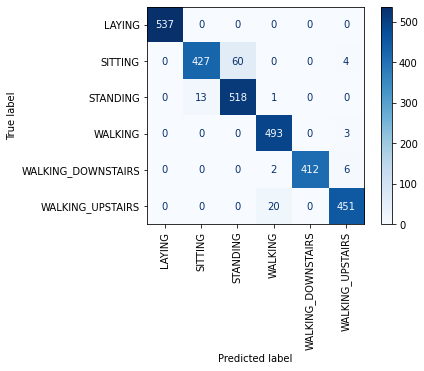

In [143]:
# Plot the confusion matrix for the test set
conf_mat = confusion_matrix(y_test_label, y_pred_label)


plot_confusion_matrix(pipe_final, X_test, y_test,
                                 display_labels=le.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize=None, xticks_rotation = 'vertical');

From the confusion matrix, we can evaluate which targets are likely to be misclassified by the model and tweak the model accordingly. 
In this case, we can see that the model oftens performs badly and confuses between SITTING and STANDING activites which also makes sense since there is no motion captured by the accelerometer during both the activites and our model has a hard time classifying them into one or other. It miscalssified 60 instances of sitting as standing which is important to note.

In [135]:
# Classification Report for the test set using the best model.
print(classification_report(y_test_label, y_pred_label))

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.97      0.87      0.92       491
          STANDING       0.90      0.97      0.93       532
           WALKING       0.96      0.99      0.97       496
WALKING_DOWNSTAIRS       1.00      0.98      0.99       420
  WALKING_UPSTAIRS       0.97      0.96      0.96       471

          accuracy                           0.96      2947
         macro avg       0.97      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



We choose f1_score as the evaluation metric since accuracy can be misleading in the case of classification scenarios.
F1 score is a combination of both precision and recall of the model on the data and from better f1 scores we can estimate for multiple target classes how the model performed in classifying the data. 
This will also give an intuition on the how often the model has misclassified certain targets as false negatives.

From the classification report, we observe the individual precision and recalls for the traget classes. The recall for sitting is less as inferred from the confusion matrix. The precision for standing is lesser since our model tends to classify them as sitting. 


In [155]:
from sklearn.inspection import permutation_importance

r = permutation_importance(pipe_final, 
                           X_test, y_test, # Using a held-out set makes it possible to highlight which features contribute the most to the generalization power of the inspected model. 
                           n_repeats=10,
                           random_state=99)

In [160]:
# According to the model, the top 10 important features for predicting the targets are:

count = 0
for i in r.importances_mean.argsort()[::-1]:
    print(f"{X.columns[i]} - "
          f"{r.importances_mean[i]:.3f}"
          f" ± {r.importances_std[i]:.3f}")
    count += 1
    if count == 10:
        break
        

tBodyGyroJerk-entropy()-X - 0.202 ± 0.007
tBodyAccJerk-entropy()-Z - 0.048 ± 0.003
tGravityAcc-mean()-Y - 0.048 ± 0.005
tGravityAcc-mean()-X - 0.037 ± 0.003
tGravityAcc-min()-X - 0.026 ± 0.002
tGravityAcc-max()-X - 0.023 ± 0.003
fBodyGyro-entropy()-X - 0.022 ± 0.002
tBodyGyroJerk-entropy()-Y - 0.020 ± 0.002
fBodyAccMag-energy() - 0.017 ± 0.002
tBodyAcc-min()-Z - 0.014 ± 0.002


## Final Model


From the above results, the proposed final model is LogisticRegression Classifier for classification of acitivties from the sensor activity readings

In [165]:
# Final Model
pipe_final.get_params()['clf']

LogisticRegression(C=2.7825594022071245, n_jobs=-1, penalty='l1',
                   solver='liblinear')

In [166]:
# Pipeline Steps
pipe_final

Pipeline(steps=[('sc', StandardScaler()),
                ('imputer',
                 SimpleImputer(add_indicator=True, strategy='median')),
                ('clf',
                 LogisticRegression(C=2.7825594022071245, n_jobs=-1,
                                    penalty='l1', solver='liblinear'))])

In [167]:
#Final Model Parameters
pipe_final.get_params()['clf'].get_params()

{'C': 2.7825594022071245,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

The best model for classifying the daily activities of humans from the readings of sensors in a smartphone is a LogisticRegression multiclass model with a l1 penalty with an f1 metric of 0.96. 

The stacked model didnot work as expected which can be because of overfitting on the training data and since it takes a lot of runtime it is difficult to scale in production. The simple logistic regression model can used as production grade which can process real time feed from the smartphones and analyse the type of activity being done by the user.

One significant observation is that it is difficult to predict similar activities like Sitting,Standing where there is less  difference in the readings of accelerometer and gyrometer. We may need additional information/data to tackle these kinds of limitations.

HAR classification can be useful in many fileds like healthcare, fitness industry etc. The end user can be given recommendations/ suggestions based on these activities which makes 

As the target classes scale, we can monitor additional features and maybe timestamp related data to determine how long the activity has been carried out, determine unique user specific activity patterns for instance identifying an user based on the walking style.